# Experiment to find the best-performing configuration for the CVAE.

The configuration will be found using the MNIST dataset

In [10]:
# First we import the model and create all the utils
from typing import Union, Callable, List, Tuple, Optional
from attr import dataclass
from project.infrastructure.images.CVAE import CVAE
from utils.batches.application.batch_selector import BatchSelector
from utils.epsilons.application.epsilon_generator_selector import EpsilonGeneratorSelector
from utils.external.fid.fid import frechet_inception_distance
from utils.external.tvd.tvd import total_variation_distance
from utils.losses.images.application.image_loss_function_selector import ImageLossFunctionSelector
import tensorflow as tf
import numpy as np


@dataclass(frozen=True)
class EncoderArchitecture:
    architecture : List[Union[int, str]]
    sizes: List[int]
    strides: List[int]

@dataclass(frozen=True)
class DecoderArchitecture:
    architecture : List[int]
    sizes: List[int]
    strides: List[int]
    decoder_input_reshape: Tuple[int, int, int]

@dataclass(frozen=True)
class ExperimetModel:
    model: CVAE
    encoder: EncoderArchitecture
    decoder: DecoderArchitecture
    encoder_output_activation: Union[str, Callable, None]
    decoder_output_activation: Union[str, Callable, None]
    loss:str
    learning_rate: float
    n_distributions: int
    fid: Optional[float] = None
    tvd: Optional[float] = None
    fids: Optional[List[float]] = None
    tvds: Optional[List[float]] = None

ENCODER_ARCHITECTURES = [
    EncoderArchitecture(
        architecture=[16, "max_pool", 32, "max_pool"],
        sizes = [3,2,3,2],
        strides = [1,1,1,1],
    ),
    EncoderArchitecture(
        architecture=[8,16, "max_pool", 32, "max_pool"],
        sizes = [3,3,2,3,2],
        strides = [1,1,1,1,1],
    ),
    EncoderArchitecture(
        architecture=[16, "max_pool", 32, "max_pool", 60],
        sizes = [3,3,2,3,2],
        strides = [1,1,1,1,1],
    ),
    EncoderArchitecture(
        architecture=[16, "max_pool", 32, "max_pool", 60],
        sizes = [3,2,3,2,3],
        strides = [1,1,1,1,1],
    ),
    EncoderArchitecture(
        architecture=[16, 32, 60],
        sizes = [3,3,3],
        strides = [1,1,1],
    ),
    EncoderArchitecture(
        architecture=[16,32,63],
        sizes = [3,3,3],
        strides = [1,2,2],
    ),
]
DECODER_ARCHITECTURES = [
    DecoderArchitecture(
        architecture=[60,48,32,16],
        sizes = [3,3,3,3],
        strides = [1,1,1,1],
        decoder_input_reshape=(28,28,32)
    ),
    DecoderArchitecture(
        architecture=[60,32,16],
        sizes = [3,3,3],
        strides = [2,1,2],
        decoder_input_reshape=(7,7,32)
    ),
    DecoderArchitecture(
        architecture=[60,48,32,16],
        sizes = [3,3,3,3],
        strides = [1,2,1,1],
        decoder_input_reshape=(14,14,32)
    ),
    DecoderArchitecture(
        architecture=[60,32,16],
        sizes = [3,3,3],
        strides = [2,2,1],
        decoder_input_reshape=(7,7,32)
    ),
]

(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.mnist.load_data()
HEIGHT = 28
WIDTH = 28
CHANNELS = 1

def create_inception_mnist_model():
    tmp_model = tf.keras.Sequential()

    # First Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    tmp_model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    tmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
    tmp_model.add(tf.keras.layers.Dropout(0.5))
    tmp_model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return tmp_model

# Preprocess MNIST dataset
x_train = TRAIN_IMAGES.reshape((-1, 28,28,1))
x_test = TEST_IMAGES.reshape((-1, 28,28,1))
x_train = tf.cast(x_train, dtype=tf.float32) / 255.0
x_test = tf.cast(x_test, dtype=tf.float32) / 255.0
y_train = tf.keras.utils.to_categorical(TRAIN_LABELS, num_classes=10)
y_test = tf.keras.utils.to_categorical(TEST_LABELS, num_classes=10)

model = create_inception_mnist_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

def get_classification(x: tf.Tensor) -> tf.Tensor:
    raw_clasification = model.predict(x)
    classif = []

    for raw in raw_clasification:
        tmp = tf.where(raw == tf.reduce_max(raw), 1.0, 0.0).tolist()
        try:
            classif.append(tmp.index(1))
        except ValueError:
            max = 0
            max_cls = 0
            for cls in range(len(raw)):
                if max < raw[cls]:
                    max = raw[cls]
                    max_cls = cls
            classif.append(max_cls)

    return tf.convert_to_tensor(classif)

INTERCEPTED_LAYER_INDEX = 5

intercepted_model = tf.keras.Model(inputs=model.input, outputs=model.layers[INTERCEPTED_LAYER_INDEX].output)

def get_activations(x : tf.Tensor) -> tf.Tensor:
    return tf.convert_to_tensor(intercepted_model.predict(x))

''

In [2]:
# Now we will execute the experiments

TRAINING_ITERATIONS = 5000
dataset_activations = get_activations(x_test)
dataset_labels = tf.convert_to_tensor(TEST_LABELS)

print("-------------------------------------------------")
print("      Searching for the best configuration       ")
print("-------------------------------------------------")

experiments = []

for encoder in ENCODER_ARCHITECTURES:
    for decoder in DECODER_ARCHITECTURES:
        current_model = CVAE(
            encoder_architecture=encoder.architecture,
            decoder_architecture=decoder.architecture,
            encoder_sizes=encoder.sizes,
            decoder_sizes=decoder.sizes,
            encoder_strides=encoder.strides,
            decoder_strides=decoder.strides,
            decoder_input_reshape=decoder.decoder_input_reshape,
            encoder_activations=[tf.nn.relu for _ in range(len(encoder.architecture))],
            decoder_activations=[tf.nn.relu for _ in range(len(decoder.architecture))],
            encoder_output_activation=tf.nn.relu,
            decoder_input_activation=tf.nn.relu,
            decoder_output_activation=tf.nn.sigmoid,
            dataset=TRAIN_IMAGES,
            loss=ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
            learning_rate=0.0001,
            n_distributions=5,
            max_iter=TRAINING_ITERATIONS,
            image_height=28,
             image_width=28,
             n_channels=1,
        )

        current_model.fit_dataset(
            return_loss=True,
            epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
            batch_size=64,
            batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
            generate_samples=False,
        )

        # we select random images from the dataset
        generated_images = current_model.generate_with_random_sample(x_test.shape[0])

        generated_activations = get_activations(generated_images)

        try:
            total_variation_distance_metric = total_variation_distance(
                dataset_labels, # Similar distribution and 6 times smaller
                get_classification(
                    current_model.generate_with_random_sample(
                        TEST_LABELS.shape[0]
                    )
                ),
                [0,1,2,3,4,5,6,7,8,9]
            )
        except Exception:
            total_variation_distance_metric = np.inf

        try:
            frechet_inception_distance_metric = frechet_inception_distance(
                dataset_activations,
                generated_activations
            )
        except Exception:
            frechet_inception_distance_metric = np.inf

        print(f"FID ==================> {frechet_inception_distance_metric}")
        print(f"TVD ==================> {total_variation_distance_metric}")
        print("-------------------------------------------------")

        experiments.append(
            ExperimetModel(
                model = current_model,
                encoder = encoder,
                decoder = decoder,
                encoder_output_activation=tf.nn.relu,
                decoder_output_activation=tf.nn.sigmoid,
                loss=ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
                learning_rate=0.0001,
                n_distributions=5,
                fid=frechet_inception_distance_metric,
                tvd=total_variation_distance_metric,
            )
        )

313/313 [==============================] - 1s 3ms/step
-------------------------------------------------
      Searching for the best configuration       
-------------------------------------------------
313/313 [==============================] - 1s 4ms/step
FID ==================> 366.6127239985385
TVD ==================> 0.8665999999999999
-------------------------------------------------
313/313 [==============================] - 1s 4ms/step
FID ==================> 360.8659024130075
TVD ==================> 0.761
-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ==================> 177.68711469687588
TVD ==================> 0.1191
-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ==================> 232.82874633937305
TVD ==================> 0.2934
-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ===========

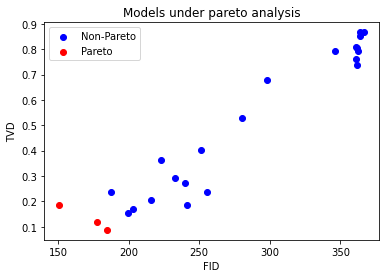

In [5]:
# Now we will analyze the experiments and see the results

#Firstly we will perform a pareto analysis over the FID and TVD metrics

pareto_set = []
non_pareto_set = []
sorted_data = sorted(experiments, key=lambda m: (m.fid, m.tvd))

# Initialize the minimum y value found so far
min_tvd = float('inf')

# Iterate over the sorted data
for m in sorted_data:
    # Check if the current point dominates the previously found points
    if m.tvd < min_tvd:
        pareto_set.append(m)
        min_tvd = m.tvd
    else:
        non_pareto_set.append(m)

#Now we will plot the models that are not dominated by one metric
import matplotlib.pyplot as plt

# Separate the points into Pareto set and non-Pareto set
pareto_x = [m.fid for m in pareto_set]
pareto_y = [m.tvd for m in pareto_set]

non_pareto_x = [m.fid for m in non_pareto_set]
non_pareto_y = [m.tvd for m in non_pareto_set]

plt.figure()
plt.scatter(non_pareto_x, non_pareto_y, color='blue', label='Non-Pareto')
plt.scatter(pareto_x, pareto_y, color='red', label='Pareto')
plt.title('Models under pareto analysis')
plt.xlabel('FID')
plt.ylabel('TVD')
plt.legend()

# Display the plot
plt.show()

Now that the pareto analysis has been performed, we will explore the consistency of both of the metrics during the training process to decide if one of the pareto models stands out

313/313 [==============================] - 1s 4ms/step
FID ==================> 262.1063678446185
TVD ==================> 0.13830000000000003


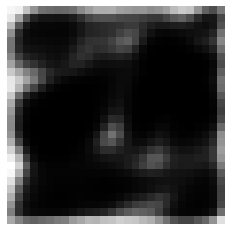

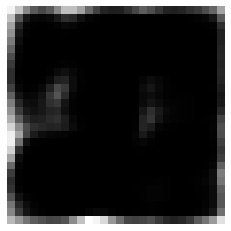

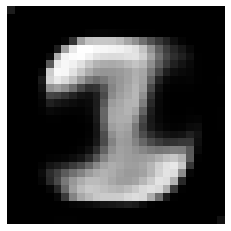

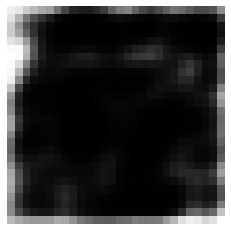

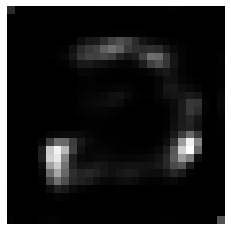

-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ==================> 192.73733409939607
TVD ==================> 0.09899999999999999


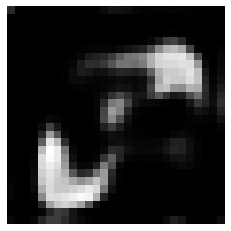

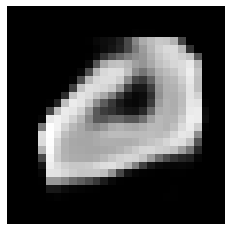

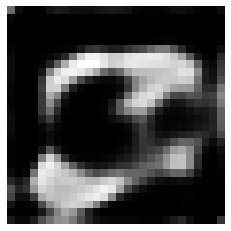

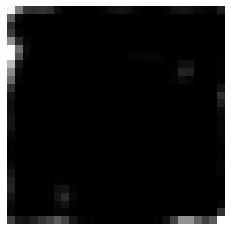

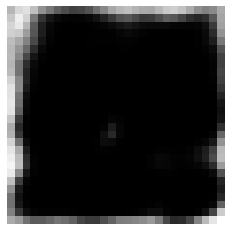

-------------------------------------------------
313/313 [==============================] - 1s 4ms/step
FID ==================> 174.00576066277108
TVD ==================> 0.09399999999999999


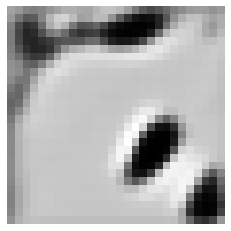

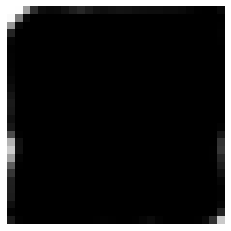

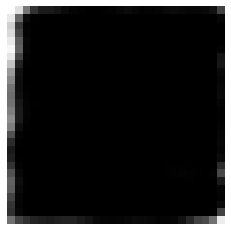

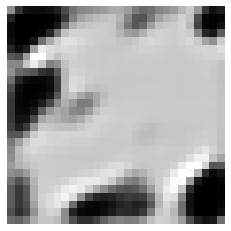

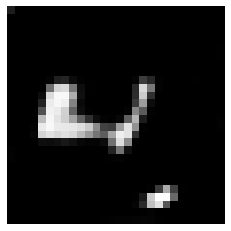

-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ==================> 163.68047532115412
TVD ==================> 0.103


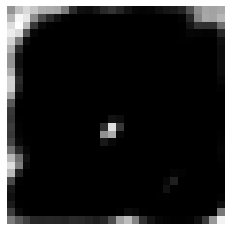

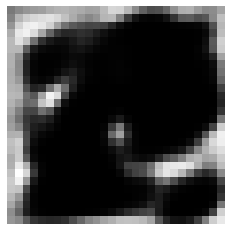

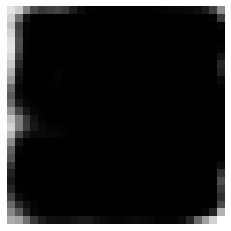

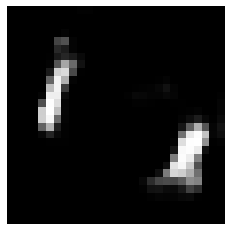

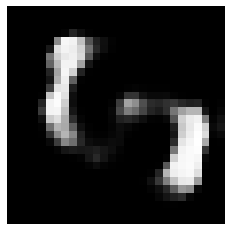

-------------------------------------------------
313/313 [==============================] - 1s 5ms/step
FID ==================> 157.019962379863
TVD ==================> 0.1168


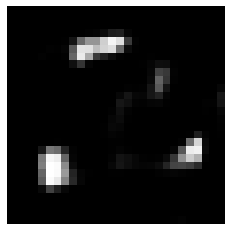

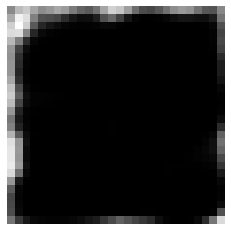

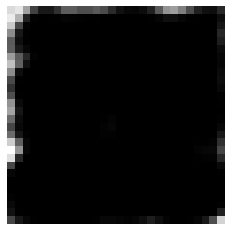

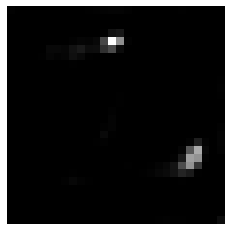

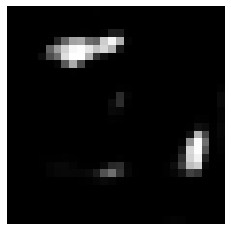

-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ==================> 350.2236709070621
TVD ==================> 0.6063


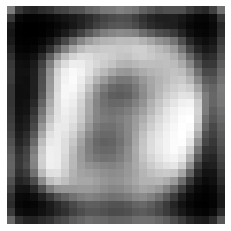

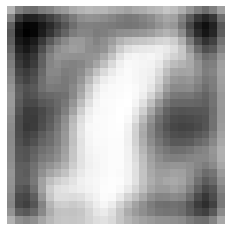

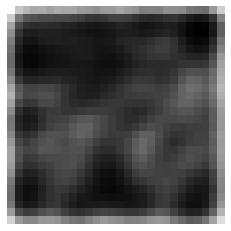

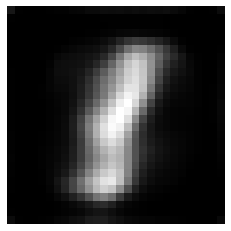

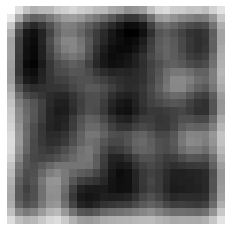

-------------------------------------------------
313/313 [==============================] - 1s 5ms/step
FID ==================> 347.92482588726665
TVD ==================> 0.6580999999999999


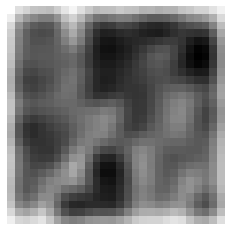

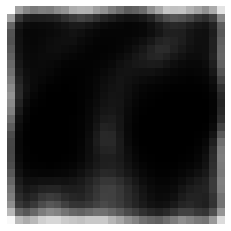

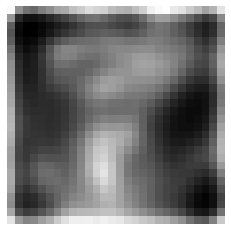

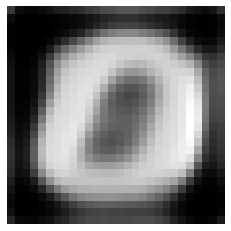

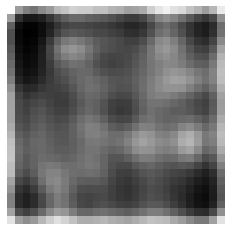

-------------------------------------------------
313/313 [==============================] - 1s 4ms/step
FID ==================> 345.65049561247713
TVD ==================> 0.6599999999999999


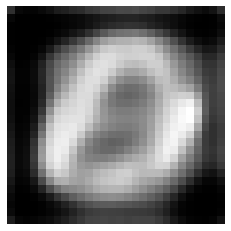

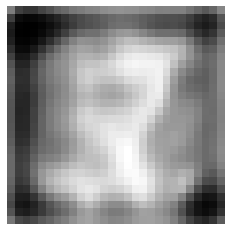

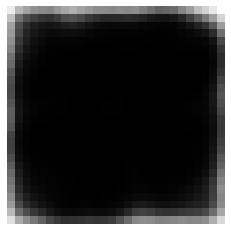

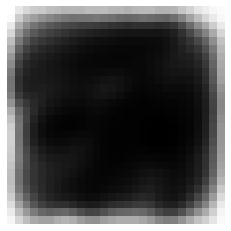

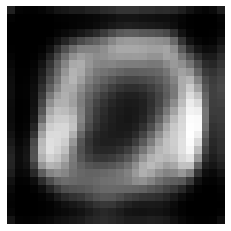

-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ==================> 342.42804018965245
TVD ==================> 0.6550999999999999


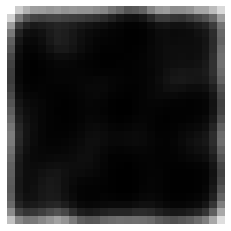

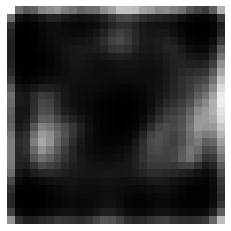

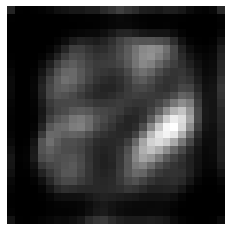

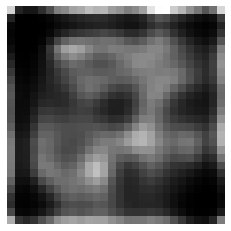

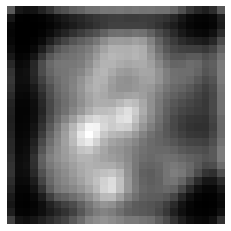

-------------------------------------------------
313/313 [==============================] - 1s 4ms/step
FID ==================> 312.84352194256064
TVD ==================> 0.5309999999999999


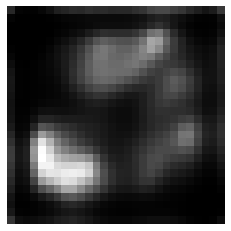

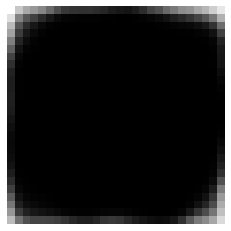

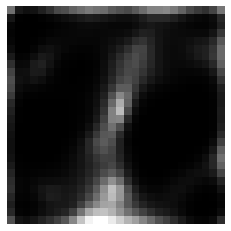

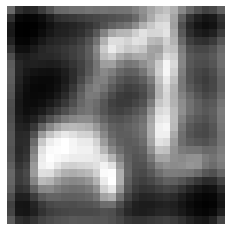

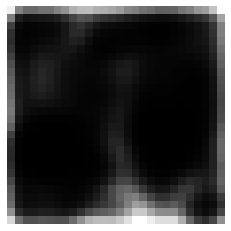

-------------------------------------------------
313/313 [==============================] - 1s 4ms/step
FID ==================> 367.6063810995488
TVD ==================> 0.8817999999999999


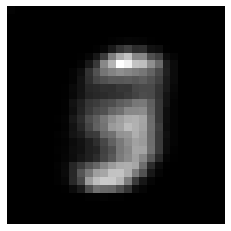

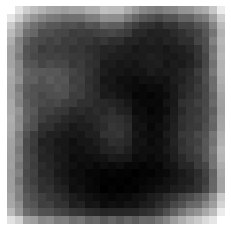

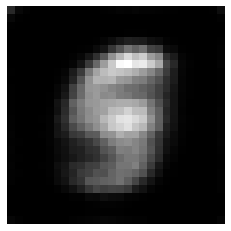

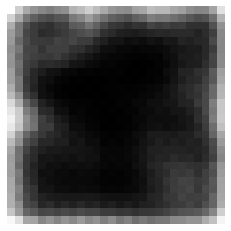

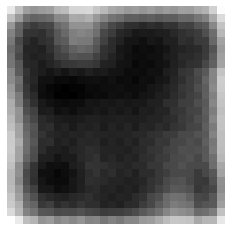

-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ==================> 366.8329167121742
TVD ==================> 0.8746999999999999


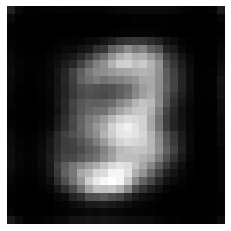

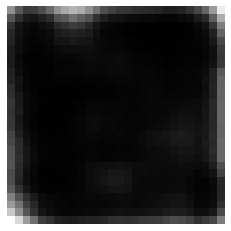

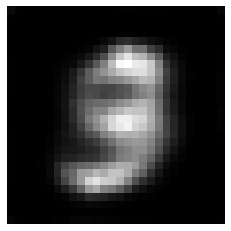

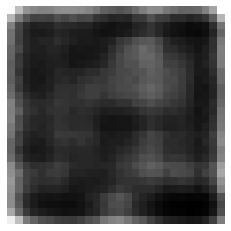

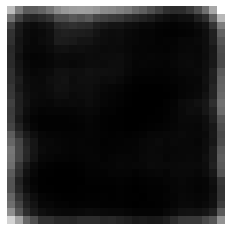

-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ==================> 366.51928328834947
TVD ==================> 0.8696999999999999


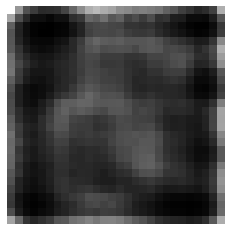

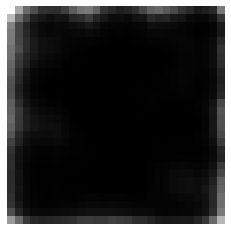

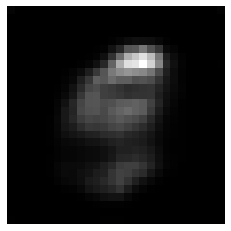

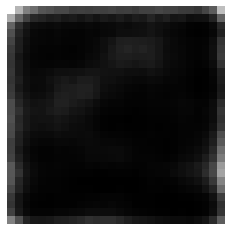

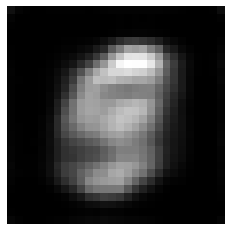

-------------------------------------------------
313/313 [==============================] - 2s 5ms/step
FID ==================> 366.16839043917383
TVD ==================> 0.8661


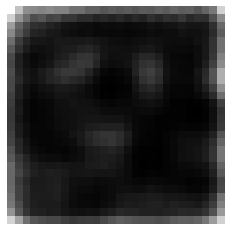

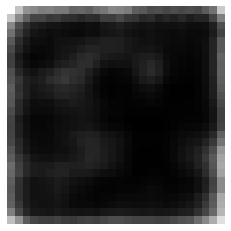

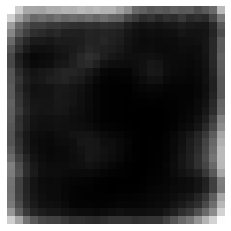

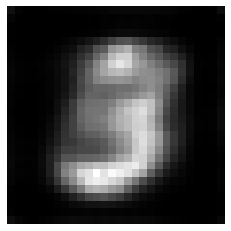

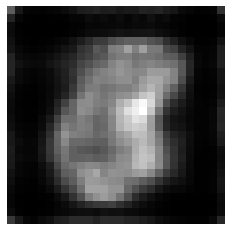

-------------------------------------------------
313/313 [==============================] - 1s 5ms/step
FID ==================> 366.0675130201062
TVD ==================> 0.868


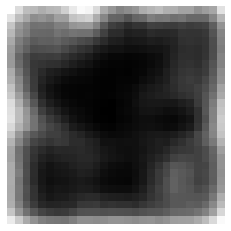

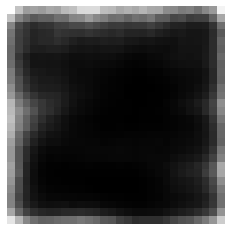

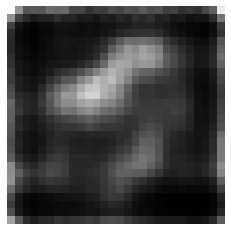

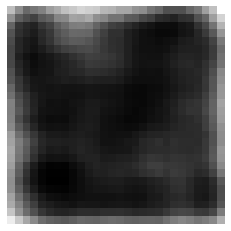

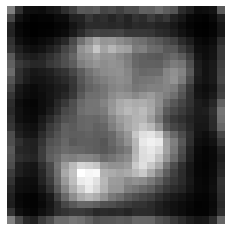

-------------------------------------------------


In [11]:
ITERATIONS = 1000
N_TRAININGS = 5
post_experiments = []

for pareto_model in pareto_set:
    current_model = CVAE(
        encoder_architecture=pareto_model.encoder.architecture,
        decoder_architecture=pareto_model.decoder.architecture,
        encoder_sizes=pareto_model.encoder.sizes,
        decoder_sizes=pareto_model.decoder.sizes,
        encoder_strides=pareto_model.encoder.strides,
        decoder_strides=pareto_model.decoder.strides,
        decoder_input_reshape=pareto_model.decoder.decoder_input_reshape,
        encoder_activations=[tf.nn.relu for _ in range(len(pareto_model.encoder.architecture))],
        decoder_activations=[tf.nn.relu for _ in range(len(pareto_model.decoder.architecture))],
        encoder_output_activation=tf.nn.relu,
        decoder_input_activation=tf.nn.relu,
        decoder_output_activation=tf.nn.sigmoid,
        dataset=TRAIN_IMAGES,
        loss=ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
        learning_rate=0.0001,
        n_distributions=5,
        max_iter=ITERATIONS,
        image_height=28,
         image_width=28,
         n_channels=1,
    )

    fids = []
    tvds = []
    for i in range(1, N_TRAININGS+1):
        current_model.fit_dataset(
            return_loss=True,
            epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
            batch_size=64,
            batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
            generate_samples=False,
        )

        # we select random images from the dataset
        generated_images = current_model.generate_with_random_sample(x_test.shape[0])

        generated_activations = get_activations(generated_images)

        try:
            total_variation_distance_metric = total_variation_distance(
                dataset_labels, # Similar distribution and 6 times smaller
                get_classification(
                    current_model.generate_with_random_sample(
                        TEST_LABELS.shape[0]
                    )
                ),
                [0,1,2,3,4,5,6,7,8,9]
            )
        except Exception:
            total_variation_distance_metric = np.inf

        try:
            frechet_inception_distance_metric = frechet_inception_distance(
                dataset_activations,
                generated_activations
            )
        except Exception:
            frechet_inception_distance_metric = np.inf

        fids.append(frechet_inception_distance_metric)
        tvds.append(total_variation_distance_metric)

        print(f"FID ==================> {frechet_inception_distance_metric}")
        print(f"TVD ==================> {total_variation_distance_metric}")
        current_model.generate_random_images(5,save=False)
        print("-------------------------------------------------")

    post_experiments.append(
        ExperimetModel(
            model = current_model,
            encoder = pareto_model.encoder,
            decoder = pareto_model.decoder,
            encoder_output_activation=tf.nn.relu,
            decoder_output_activation=tf.nn.sigmoid,
            loss=ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
            learning_rate=0.0001,
            n_distributions=5,
            fids=fids,
            tvds=tvds,
        )
    )

<Figure size 432x288 with 0 Axes>

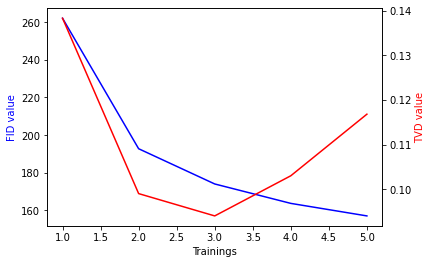

<Figure size 432x288 with 0 Axes>

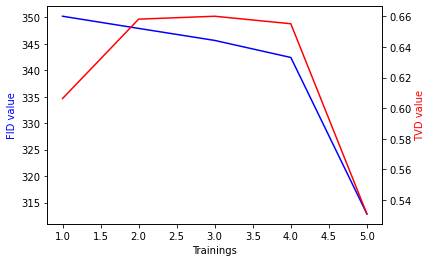

<Figure size 432x288 with 0 Axes>

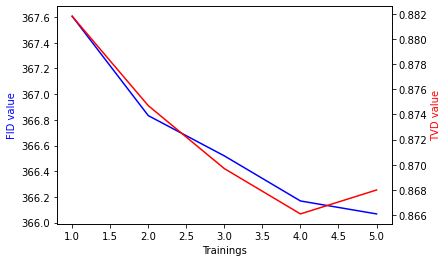

In [38]:
# Now we will see the evolution of the metrics during the training of the pareto models and evaluate if they are consistent

for m in post_experiments:
    plt.figure()
    x = [1, 2, 3, 4, 5]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, m.fids, color='blue')
    ax2.plot(x, m.tvds, color='red')

    ax1.set_xlabel('Trainings')
    ax1.set_ylabel('FID value', color='blue')
    ax2.set_ylabel('TVD value', color='red')

    # Display the plot
    plt.show()


As we can see, the FID is much more consistent than the TVD over the training. So we will train again the pareto models with more iterations and we will declare as the best the one with the lowest FID

In [23]:
ITERATIONS = 25000

final_experiment = []

for pareto_model in pareto_set:
    current_model = CVAE(
        encoder_architecture=pareto_model.encoder.architecture,
        decoder_architecture=pareto_model.decoder.architecture,
        encoder_sizes=pareto_model.encoder.sizes,
        decoder_sizes=pareto_model.decoder.sizes,
        encoder_strides=pareto_model.encoder.strides,
        decoder_strides=pareto_model.decoder.strides,
        decoder_input_reshape=pareto_model.decoder.decoder_input_reshape,
        encoder_activations=[tf.nn.relu for _ in range(len(pareto_model.encoder.architecture))],
        decoder_activations=[tf.nn.relu for _ in range(len(pareto_model.decoder.architecture))],
        encoder_output_activation=tf.nn.relu,
        decoder_input_activation=tf.nn.relu,
        decoder_output_activation=tf.nn.sigmoid,
        dataset=TRAIN_IMAGES,
        loss=ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
        learning_rate=0.0001,
        n_distributions=5,
        max_iter=ITERATIONS,
        image_height=28,
         image_width=28,
         n_channels=1,
    )

    current_model.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = current_model.generate_with_random_sample(x_test.shape[0])

    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    print(f"FID ==================> {frechet_inception_distance_metric}")
    print("-------------------------------------------------")

    final_experiment.append(
        ExperimetModel(
            model = current_model,
            encoder = pareto_model.encoder,
            decoder = pareto_model.decoder,
            encoder_output_activation=tf.nn.relu,
            decoder_output_activation=tf.nn.sigmoid,
            loss=ImageLossFunctionSelector.ImageLosses.Dkl_MSE.value,
            learning_rate=0.0001,
            n_distributions=5,
            fid=frechet_inception_distance_metric,
        )
    )

313/313 [==============================] - 2s 6ms/step
FID ==================> 127.3511862381697
-------------------------------------------------
313/313 [==============================] - 1s 4ms/step
FID ==================> 200.5436817006126
-------------------------------------------------
313/313 [==============================] - 1s 4ms/step
FID ==================> 362.0621327142479
-------------------------------------------------


ACCORDING TO THE EXPERIMENT, THE BEST PERFORMING CVAE MODEL IS:

ENCODER:
    Architecture =======> [16, 32, 63]
    Sizes ==============> [3, 3, 3]
    Strides ============> [1, 2, 2]

DECODER:
    Architecture =======> [60, 48, 32, 16]
    Sizes ==============> [3, 3, 3, 3]
    Strides ============> [1, 2, 1, 1]
    Reshape ============> (14, 14, 32)

EXAMPLE OF GENERATION:



<Figure size 432x288 with 0 Axes>

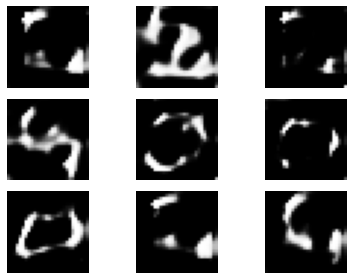

<Figure size 432x288 with 0 Axes>

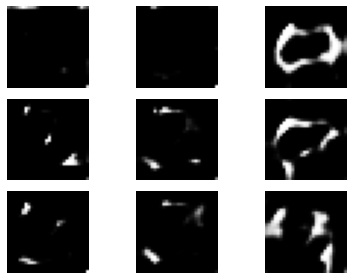

<Figure size 432x288 with 0 Axes>

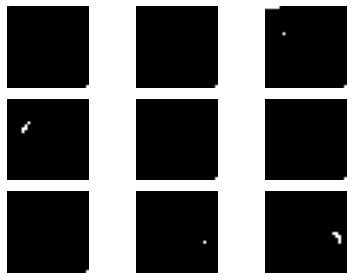

In [41]:
best = min(final_experiment, key=lambda m: m.fid)

print("ACCORDING TO THE EXPERIMENT, THE BEST PERFORMING CVAE MODEL IS:\n")
print("ENCODER:")
print(f"    Architecture =======> {best.encoder.architecture}")
print(f"    Sizes ==============> {best.encoder.sizes}")
print(f"    Strides ============> {best.encoder.strides}\n")
print("DECODER:")
print(f"    Architecture =======> {best.decoder.architecture}")
print(f"    Sizes ==============> {best.decoder.sizes}")
print(f"    Strides ============> {best.decoder.strides}")
print(f"    Reshape ============> {best.decoder.decoder_input_reshape}\n")

best_generated_1=best.model.generate_with_multiple_samples(
    tf.random.normal((9,5))
)
best_generated_2=best.model.generate_with_multiple_samples(
    tf.random.normal((9,5))
)

best_generated_times100=best.model.generate_with_multiple_samples(
    tf.random.normal((9,5))*100
)

#Now we generate a 3x3 image
print("EXAMPLE OF GENERATION:\n")
plt.figure()
fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flat):
    image = best_generated_1[i]

    ax.imshow(image, cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()

plt.figure()
fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flat):
    image = best_generated_2[i]

    ax.imshow(image, cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()

plt.figure()
fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flat):
    image = best_generated_times100[i]

    ax.imshow(image, cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()